<h1>Hands on Session </h1>
This notebook gives the step by step instructions on how to create Boosted Model on Store Sales Dataset from Kaggle
from Kaggle.

## Import the packages required for the excersice

In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
import math
import warnings
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline
warnings.filterwarnings('ignore')

In [6]:
print("Load the training, test and store data using pandas")
train = pd.read_csv("train.csv")
store = pd.read_csv("store.csv")

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_columns', 160)


Load the training, test and store data using pandas


In [25]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,year,month,day
0,1,5,2015-07-31,5263,555,1,1,0,1.0,3.0,1.0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015.0,7.0,31.0
1,1,4,2015-07-30,5020,546,1,1,0,1.0,3.0,1.0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015.0,7.0,30.0
2,1,3,2015-07-29,4782,523,1,1,0,1.0,3.0,1.0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015.0,7.0,29.0
3,1,2,2015-07-28,5011,560,1,1,0,1.0,3.0,1.0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015.0,7.0,28.0
4,1,1,2015-07-27,6102,612,1,1,0,1.0,3.0,1.0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015.0,7.0,27.0


In [8]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [9]:
print("Consider only open stores for training. Closed stores wont count into the score.")
train = train[train["Open"] != 0]

print("Join with store")
train = pd.merge(train, store, on='Store')


Consider only open stores for training. Closed stores wont count into the score.
Join with store


In [10]:
##### Function to visualize plotly graphs ######
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

In [11]:
# Thanks to Chenglong Chen for providing this in the forum
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

## Feature Engineering to remove Sequentiality

In [12]:
# Gather some features
def build_features(features, data):
    # remove NaNs
    data.fillna(0, inplace=True)
    data.loc[data.Open.isnull(), 'Open'] = 1
    features.extend(['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                     'CompetitionOpenSinceYear', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear'])

    features.append('SchoolHoliday')
    data['SchoolHoliday'] = data['SchoolHoliday'].astype(float)
    features.append('DayOfWeek')
    features.append('month')
    features.append('day')
    features.append('year')
    data['year'] = data.Date.apply(lambda x: x.split('-')[0])
    data['year'] = data['year'].astype(float)
    data['month'] = data.Date.apply(lambda x: x.split('-')[1])
    data['month'] = data['month'].astype(float)
    data['day'] = data.Date.apply(lambda x: x.split('-')[2])
    data['day'] = data['day'].astype(float)

    features.append('StoreType')
    data.loc[data['StoreType'] == 'a', 'StoreType'] = '1'
    data.loc[data['StoreType'] == 'b', 'StoreType'] = '2'
    data.loc[data['StoreType'] == 'c', 'StoreType'] = '3'
    data.loc[data['StoreType'] == 'd', 'StoreType'] = '4'
    data['StoreType'] = data['StoreType'].astype(float)

    features.append('Assortment')
    data.loc[data['Assortment'] == 'a', 'Assortment'] = '1'
    data.loc[data['Assortment'] == 'b', 'Assortment'] = '2'
    data.loc[data['Assortment'] == 'c', 'Assortment'] = '3'
    data['Assortment'] = data['Assortment'].astype(float)


### Apply the Changes

In [13]:
features = []

print("augment features")
build_features(features, train)
print(features)

augment features
['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'DayOfWeek', 'month', 'day', 'year', 'StoreType', 'Assortment']


In [14]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,year,month,day
0,1,5,2015-07-31,5263,555,1,1,0,1.0,3.0,1.0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015.0,7.0,31.0
1,1,4,2015-07-30,5020,546,1,1,0,1.0,3.0,1.0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015.0,7.0,30.0
2,1,3,2015-07-29,4782,523,1,1,0,1.0,3.0,1.0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015.0,7.0,29.0
3,1,2,2015-07-28,5011,560,1,1,0,1.0,3.0,1.0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015.0,7.0,28.0
4,1,1,2015-07-27,6102,612,1,1,0,1.0,3.0,1.0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015.0,7.0,27.0


## Model Development

### Create the Train - Test Split based on Time

In [15]:
X_train = train[train.Date < '2015-04-01']
X_test = train[train.Date >= '2015-04-01']

### Specifying Parameters on XGBOOST

In [16]:
params = {"objective": "reg:linear",
          "eta": 0.3,
          "max_depth": 8,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 300
print("Train a XGBoost model")
dtrain = xgb.DMatrix(X_train[features], np.log(X_train["Sales"] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test["Sales"] + 1))

Train a XGBoost model


### Fit the Algorithm

In [17]:
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50, feval=rmspe_xg, verbose_eval=True)

print("Validating")
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['Sales'].values)
print('error', error)


[0]	eval-rmse:5.84628	train-rmse:5.79011	eval-rmspe:0.996997	train-rmspe:0.996772
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 50 rounds.
[1]	eval-rmse:4.12069	train-rmse:4.06238	eval-rmspe:0.982471	train-rmspe:0.981271
[2]	eval-rmse:2.91346	train-rmse:2.85427	eval-rmspe:0.941509	train-rmspe:0.937575
[3]	eval-rmse:2.06812	train-rmse:2.01322	eval-rmspe:0.863825	train-rmspe:0.855628
[4]	eval-rmse:1.48025	train-rmse:1.4276	eval-rmspe:0.756578	train-rmspe:0.743099
[5]	eval-rmse:1.07468	train-rmse:1.02435	eval-rmspe:0.636893	train-rmspe:0.618992
[6]	eval-rmse:0.796208	train-rmse:0.750318	eval-rmspe:0.523451	train-rmspe:0.504736
[7]	eval-rmse:0.607912	train-rmse:0.567353	eval-rmspe:0.430036	train-rmspe:0.416179
[8]	eval-rmse:0.483586	train-rmse:0.44862	eval-rmspe:0.361986	train-rmspe:0.357115
[9]	eval-rmse:0.401293	train-rmse:0.372504	eval-rmspe:0.316906	train-rmspe:0.322997
[10]	eval-rmse:0.349191	tra

[96]	eval-rmse:0.157705	train-rmse:0.142207	eval-rmspe:0.15696	train-rmspe:0.16809
[97]	eval-rmse:0.157128	train-rmse:0.141764	eval-rmspe:0.156337	train-rmspe:0.167695
[98]	eval-rmse:0.156982	train-rmse:0.141558	eval-rmspe:0.156159	train-rmspe:0.168511
[99]	eval-rmse:0.156772	train-rmse:0.14139	eval-rmspe:0.155926	train-rmspe:0.168502
[100]	eval-rmse:0.156233	train-rmse:0.140871	eval-rmspe:0.155466	train-rmspe:0.167916
[101]	eval-rmse:0.155583	train-rmse:0.140015	eval-rmspe:0.154733	train-rmspe:0.166879
[102]	eval-rmse:0.155437	train-rmse:0.139882	eval-rmspe:0.154568	train-rmspe:0.166819
[103]	eval-rmse:0.15785	train-rmse:0.139444	eval-rmspe:0.154943	train-rmspe:0.166677
[104]	eval-rmse:0.157867	train-rmse:0.139378	eval-rmspe:0.154951	train-rmspe:0.166531
[105]	eval-rmse:0.157719	train-rmse:0.139151	eval-rmspe:0.154805	train-rmspe:0.166473
[106]	eval-rmse:0.157683	train-rmse:0.138734	eval-rmspe:0.154766	train-rmspe:0.16369
[107]	eval-rmse:0.158444	train-rmse:0.138433	eval-rmspe:0.15559

[192]	eval-rmse:0.153193	train-rmse:0.122812	eval-rmspe:0.149928	train-rmspe:0.141791
[193]	eval-rmse:0.152965	train-rmse:0.122672	eval-rmspe:0.149853	train-rmspe:0.141761
[194]	eval-rmse:0.152917	train-rmse:0.122549	eval-rmspe:0.149819	train-rmspe:0.141279
[195]	eval-rmse:0.153048	train-rmse:0.122426	eval-rmspe:0.149868	train-rmspe:0.139987
[196]	eval-rmse:0.153193	train-rmse:0.122132	eval-rmspe:0.149966	train-rmspe:0.139865
[197]	eval-rmse:0.153165	train-rmse:0.121993	eval-rmspe:0.149895	train-rmspe:0.139886
[198]	eval-rmse:0.153155	train-rmse:0.121924	eval-rmspe:0.149872	train-rmspe:0.13983
[199]	eval-rmse:0.153305	train-rmse:0.121749	eval-rmspe:0.149925	train-rmspe:0.139723
[200]	eval-rmse:0.153863	train-rmse:0.121658	eval-rmspe:0.150269	train-rmspe:0.139533
[201]	eval-rmse:0.153839	train-rmse:0.121571	eval-rmspe:0.150221	train-rmspe:0.139689
[202]	eval-rmse:0.153847	train-rmse:0.121458	eval-rmspe:0.150213	train-rmspe:0.139609
[203]	eval-rmse:0.153827	train-rmse:0.121412	eval-rmspe

[288]	eval-rmse:0.154758	train-rmse:0.112408	eval-rmspe:0.148529	train-rmspe:0.121277
[289]	eval-rmse:0.154884	train-rmse:0.112351	eval-rmspe:0.148629	train-rmspe:0.12119
[290]	eval-rmse:0.154926	train-rmse:0.112248	eval-rmspe:0.148635	train-rmspe:0.12111
[291]	eval-rmse:0.154978	train-rmse:0.112193	eval-rmspe:0.148644	train-rmspe:0.120918
[292]	eval-rmse:0.154987	train-rmse:0.112143	eval-rmspe:0.148651	train-rmspe:0.120873
[293]	eval-rmse:0.155051	train-rmse:0.11206	eval-rmspe:0.148649	train-rmspe:0.120733
[294]	eval-rmse:0.15501	train-rmse:0.111875	eval-rmspe:0.14862	train-rmspe:0.120669
[295]	eval-rmse:0.154935	train-rmse:0.111805	eval-rmspe:0.148599	train-rmspe:0.120575
[296]	eval-rmse:0.155292	train-rmse:0.111639	eval-rmspe:0.148644	train-rmspe:0.120505
[297]	eval-rmse:0.155507	train-rmse:0.111531	eval-rmspe:0.148814	train-rmspe:0.120324
[298]	eval-rmse:0.155495	train-rmse:0.111487	eval-rmspe:0.148796	train-rmspe:0.120317
[299]	eval-rmse:0.155529	train-rmse:0.111436	eval-rmspe:0.1

### Validate The Model and Comparison with Other Model

In [26]:
print("Validating")
test = pd.read_csv("train.csv")
test = pd.merge(test, store, on='Store')
features = []
build_features(features, test)
X_test = test[test.Date >= '2015-04-01']
test = X_test[X_test.Store == 6]
test["predict"] = gbm.predict(xgb.DMatrix(test[features]))
test[test[test.Store == 6]["Open"] != 0]["predict"] = 0
test["predict"] = np.where((test['Open'] == 0) ,0, test["predict"])
measure = math.pow(mean_squared_error(np.exp(test['predict'].values) - 1,test['Sales'].values), 0.5)
print("RMSE:", measure)

Validating
RMSE: 561.2436321520634


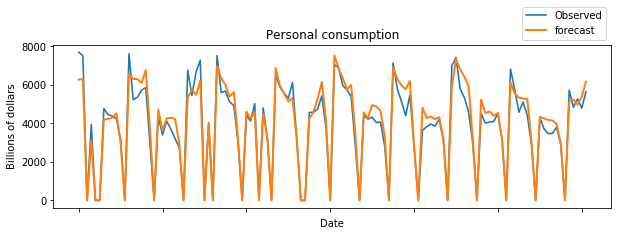

In [27]:
# Dynamic predictions
test.index = test.Date
test = test= test.sort_values("Date")

predict_dy = np.exp(test["predict"])-1

# Graph
fig, ax = plt.subplots(figsize=(10,3))
ax.set(title='Personal consumption', xlabel='Date', ylabel='Billions of dollars')

t_start='2015-01-01'
pred_start = '2014-04-01'
t_end='2015-07-31'
test.Sales.plot(ax=ax, style='-',linewidth=1.6, label='Observed')
predict_dy.plot(ax=ax,style='-',linewidth=2, label='forecast')
legend = ax.legend(loc='lower right',bbox_to_anchor=(1,1))

In [23]:
np.mean(test[test['Open'] != 0].Sales)

4801.24